<center><h1>Sound Classification <br><small>Example</small></h1></center>
<br><br>

<center style="font-size:140%;">
    <strong>Toni Heittola</strong><br>
    <small>toni.heittola@tuni.fi</small>
</center>
<table><tr>
<td><img src="images/ARG_logo.png" alt="Drawing" style="width:350px;"/></td>
    <td><img src="images/marvel_logo.png" alt="Drawing" style="width:350px;"/></td>
<td><img src="images/TAU_logo.png" alt="Drawing" style="width:250px;"/></td>
</tr></table>

# Introduction

This presentation goes through basic steps to build a **CNN**-based sound classifier. 


## Outline

- Dataset
- Cross-validation set
- Acoustic features
- Learning the acoustic model
- Testing the learned model
- Evaluation

## Example application &ndash; Acoustic scene classification

*The goal of acoustic scene classification is to classify a test recording into one of the predefined ten acoustic scene classes*

<img src="images/asc.png" width="400">

## Key tools used in this example:

- **`dcase_util`** &ndash; used to ease data handling, https://github.com/DCASE-REPO/dcase_util
- **`keras`** &ndash; neural network API for fast experimentation used on top of **`tensorflow`** machine learning framework
- **`scikit-learn`** &ndash; set of machine learning tools, here used to evaluate the system output

In [6]:
import dcase_util
from dcase_util.containers import AudioContainer
from dcase_util.features import MelExtractor
from dcase_util.data import ProbabilityEncoder
import os, numpy
import matplotlib.pyplot as plt
import sklearn
import time
%matplotlib inline

# Handy tool to print data in HTML form
log = dcase_util.ui.FancyHTMLPrinter()

# Paths to store data
data_storage_path = 'data'
dataset_storage_path = os.path.join(data_storage_path, 'datasets')
feature_storage_path = os.path.join(data_storage_path, 'features_asc')
dcase_util.utils.Path().create(
    [data_storage_path, dataset_storage_path, feature_storage_path]
)


# Filename for acoustic model
model_filename = os.path.join(data_storage_path, 'model_asc.h5')  

def get_feature_filename(audio_filename, feature_storage_path):
    """Get feature filename from audio filename. """
    
    return dcase_util.utils.Path(path=audio_filename).modify(
        path_base=feature_storage_path, 
        filename_extension='.npy'
    )
    
def get_feature_matrix(audio_filename, feature_storage_path=os.path.join('data', 'features_asc')):    
    """Extract acoustic features (log mel-energies) for given audio file and store them."""
    
    feature_filename = get_feature_filename(audio_filename, feature_storage_path)
    if os.path.exists(feature_filename):
        return numpy.load(feature_filename)
    else:
        audio = dcase_util.containers.AudioContainer().load(filename=audio_filename,mono=True)
        mel_extractor = dcase_util.features.MelExtractor(n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs)
        mel_data = mel_extractor.extract(y=audio)
        numpy.save(feature_filename, mel_data)
        return mel_data
    
# Setup Keras to use tensorflow as backend
dcase_util.tfkeras.setup_keras(backend='tensorflow', device='cuda')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

from tensorflow.keras.models import Model

from codecarbon import EmissionsTracker, OfflineEmissionsTracker
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.ERROR)

# Dataset

**`dcase_util`** implements dataset handling classes that can be used to access datasets through uniform API:

- Download the dataset from the origin, e.g. zenodo.org
- Extract downloaded Zip-packages and check data integrity 
- Access metadata (e.g. filter data based on scene labels)
- Access cross-validation sets bundled with the dataset

**TUT Urban Acoustic Scenes 2018** development dataset is used in this example:
- The dataset was used as a development dataset in [acoustic scene classfication task](https://dcase.community/challenge2018/task-acoustic-scene-classification#subtask-a) (task1A) in the DCASE2018 Challenge
- Recordings from 10 scene classes, 6 large European cities
- 5-6 minute recordings around selected locations, which were split into **10 second audio segments**
- 8640 segments in total


Dataset can be downloaded and accessed easily by using **dataset handler class** from `dcase_util`:

In [7]:
db = dcase_util.datasets.TUTUrbanAcousticScenes_2018_DevelopmentSet(
    data_path=dataset_storage_path
).initialize()

In [8]:
print('Audio file count :', len(db.audio_files))
print('Scene class count:', len(db.scene_labels()))

Audio file count : 8640
Scene class count: 10


In [9]:
print('Scene labels:', db.scene_labels())

Scene labels: ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']


Basic statistics of the dataset:

In [10]:
db.meta.show(mode='print')

MetaDataContainer :: Class
Items                               : 8640 
Unique
  Files                             : 8640 
  Scene labels                      : 10 
  Event labels                      : 0 
  Tags                              : 0 
  Identifiers                       : 286 
  Datasets                          : 0 
  Source labels                     : 1 

Scene statistics
  Scene label             Count   Identifiers   
  --------------------   ------   -----------   
  airport                   864            22   
  bus                       864            36   
  metro                     864            29   
  metro_station             864            40   
  park                      864            25   
  public_square             864            24   
  shopping_mall             864            22   
  street_pedestrian         864            28   
  street_traffic            864            25   
  tram                      864            35   




Identifiers are unique recording locations:

In [11]:
# Identifiers for items with bus scene label
db.meta.filter(scene_label='street_traffic').unique_identifiers[0:6]

['barcelona-161',
 'barcelona-162',
 'barcelona-163',
 'barcelona-268',
 'helsinki-164',
 'helsinki-165']

## Important aspects

- We need to be aware of the **recording location** of each segment
- Audio segments from the same location around the same time are **highly correlated**
- Unrealistic to be able to train the system and test it with material recorded **in the same location only a few minutes apart**
- The cross-validation set should take this into account to give **realistic performance estimates**

# Cross-validation set

- Dataset is released with a single **train/test**-split
- We need also a **validation set** to follow system performance on **unseen data** during the training process
- Dataset class from `dcase_util` can be used to split the original training set into a new training set and validation set (70/30 split done according to recording locations)

## Train/Test split bundled with the dataset

In [12]:
train_items = db.train(1).stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = db.train(1).stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_items,         
        test_items,        
        train_items / (train_items + test_items) * 100.0,
        train_ids, 
        test_ids, 
        #train_ids / ( train_ids + test_ids)* 100.0,
    ],
    column_headers=['Scene label', 'Train set (items)', 'Test set (items)', 'Split percentage', 'Train (locations)', 'Test (locations)'],
    column_types=['str18', 'int', 'int', 'int', 'int', 'int', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=100
)

Scene label,Train set (items),Test set (items),Split percentage,Train (locations),Test (locations)
airport,599,265,69,15,7
bus,622,242,71,26,10
metro,603,261,69,20,9
metro_station,605,259,70,28,12
park,622,242,71,18,7
public_square,648,216,75,18,6
shopping_mall,585,279,67,16,6
street_pedestrian,617,247,71,20,8
street_traffic,618,246,71,18,7
tram,603,261,69,24,11


## Generating validation set

- During the training, we need a **validation set** to follow system performance on **unseen data**
- The validation set can be extracted from the training set while taking location identifiers into account
- Dataset class can be used to generate a validation set and a new training set:

In [13]:
training_files, validation_files = db.validation_split(
    validation_amount=0.3, # split target 30% 
    fold=1, # cross-validation fold id      
    # balance based on scenes and locations
    balancing_mode='identifier_two_level_hierarchy', 
    disable_progress_bar=True
)

train_meta = db.train(1).filter(file_list=training_files)
validation_meta = db.train(1).filter(file_list=validation_files)

In [14]:
print('Training items  :', len(training_files))
print('Validation items:', len(validation_files))

Training items  : 4134
Validation items: 1988


## Train / Validation statistics

In [15]:
train_items = train_meta.stats()['scenes']['count']
train_items = numpy.append(train_items, numpy.sum(train_items))
train_ids = train_meta.stats()['scenes']['identifiers']
train_ids = numpy.append(train_ids, numpy.sum(train_ids))

validation_items = validation_meta.stats()['scenes']['count']
validation_items = numpy.append(validation_items, numpy.sum(validation_items))
validation_ids = validation_meta.stats()['scenes']['identifiers']
validation_ids = numpy.append(validation_ids, numpy.sum(validation_ids))

test_items = db.eval(1).stats()['scenes']['count']
test_items = numpy.append(test_items, numpy.sum(test_items))
test_ids = db.eval(1).stats()['scenes']['identifiers']
test_ids = numpy.append(test_ids, numpy.sum(test_ids))
labels = db.scene_labels() 
labels.append('Overall')

log.table(
    cell_data=[
        labels, 
        train_ids, 
        validation_ids, 
        validation_ids / ( train_ids + validation_ids)* 100.0,
        #test_ids,         

        train_items,         
        validation_items,  
        validation_items / (train_items + validation_items) * 100.0,
        #test_items,        

    ],
    column_headers=['Scene label', 
                    'Train (locations)', 'Validation (locations)', 'Split percentage', 
                    #'Test (locations)',
                    'Train set (items)', 'Validation set (items)', 'Split percentage', 
                    #'Test set (items)',
                   
                   ],
    column_types=['str17', 'int', 'int', 'float1', 'int', 'int', 'float1', 'int'],
    column_separators=[0,3],
    row_separators=[10],
    scaling=110
)

Scene label,Train (locations),Validation (locations),Split percentage,Train set (items),Validation set (items),Split percentage
airport,9,6,40.0,411,188,31.4
bus,16,10,38.5,413,209,33.6
metro,13,7,35.0,422,181,30.0
metro_station,18,10,35.7,408,197,32.6
park,12,6,33.3,425,197,31.7
public_square,12,6,33.3,433,215,33.2
shopping_mall,10,6,37.5,360,225,38.5
street_pedestrian,13,7,35.0,422,195,31.6
street_traffic,12,6,33.3,425,193,31.2
tram,16,8,33.3,415,188,31.2


# Features &ndash; log-mel energies

Feature extractor initialized with parameters and used to extract features:

In [16]:
# Load audio 
audio = dcase_util.containers.AudioContainer().load(
    filename=db.audio_files[0], mono=True
)

# Create feature extractor
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, 
    win_length_seconds=0.04, 
    hop_length_seconds=0.02, 
    fs=audio.fs
)

# Extract features
mel_data = mel_extractor.extract(y=audio)

## Feature matrix

In [17]:
print('mel_data shape', '(frequency, time):\n', mel_data.shape)

mel_data shape (frequency, time):
 (40, 501)


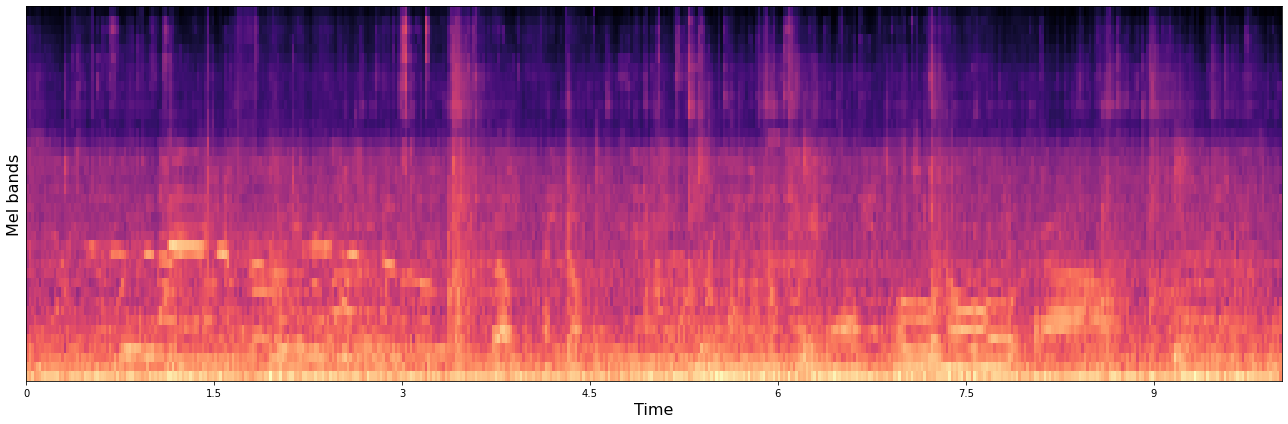

In [18]:
dcase_util.containers.FeatureContainer(
    data=mel_data,
    time_resolution=mel_extractor.hop_length_seconds
).plot(
    ylabel='Mel bands',
    xlabel='Time',
    figsize=(18,6)
)

# Learning examples

1) **Feature matrix**

In [19]:
# Load audio
audio = dcase_util.containers.AudioContainer().load(
    filename=train_meta[0].filename, mono=True
)

# Extract log-mel energies
sequence_length = 500        # 10s / 0.02s = 500
mel_extractor = dcase_util.features.MelExtractor(
    n_mels=40, win_length_seconds=0.04, hop_length_seconds=0.02, fs=audio.fs
)

features = mel_extractor.extract(audio.data)[:,:sequence_length]

In [20]:
print('features shape', '(frequency, time):\n', features.shape)

features shape (frequency, time):
 (40, 500)


2) **Target vector** (one-hot encoded vector)

In [21]:
# List of scene labels
scene_labels = db.scene_labels()               

# Empty target vector
target_vector = numpy.zeros(len(scene_labels))      

# Place one at correct position 
target_vector[scene_labels.index(train_meta[0].scene_label)] = 1

In [22]:
target_vector

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
print('target vector shape', '(classes, ):\n', target_vector.shape)

target vector shape (classes, ):
 (10,)


# Collect training data

In [24]:
X_train = []
Y_train = []
for item in train_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_train.append(features) 
    Y_train.append(target_vector)
    
X_train = numpy.moveaxis(numpy.dstack(X_train), 2, 0)
Y_train = numpy.vstack(Y_train)
print('X_train shape', X_train.shape)
print('Y_train shape', Y_train.shape)

Load audio/airport-barcelona-1-16-a.wav
Load audio/airport-barcelona-1-17-a.wav
Load audio/airport-barcelona-1-18-a.wav
Load audio/airport-barcelona-1-19-a.wav
Load audio/airport-barcelona-1-20-a.wav
Load audio/airport-barcelona-1-21-a.wav
Load audio/airport-barcelona-1-22-a.wav
Load audio/airport-barcelona-1-23-a.wav
Load audio/airport-barcelona-1-24-a.wav
Load audio/airport-barcelona-1-25-a.wav
Load audio/airport-barcelona-1-26-a.wav
Load audio/airport-barcelona-1-27-a.wav
Load audio/airport-barcelona-1-28-a.wav
Load audio/airport-barcelona-1-29-a.wav
Load audio/airport-barcelona-1-30-a.wav
Load audio/airport-barcelona-1-31-a.wav
Load audio/airport-barcelona-1-32-a.wav
Load audio/airport-barcelona-1-33-a.wav
Load audio/airport-barcelona-1-34-a.wav
Load audio/airport-barcelona-1-35-a.wav
Load audio/airport-barcelona-1-36-a.wav
Load audio/airport-barcelona-1-37-a.wav
Load audio/airport-barcelona-1-38-a.wav
Load audio/airport-barcelona-1-39-a.wav
Load audio/airport-barcelona-1-40-a.wav


Load audio/bus-london-21-819-a.wav
Load audio/bus-london-21-820-a.wav
Load audio/bus-london-21-821-a.wav
Load audio/bus-london-21-822-a.wav
Load audio/bus-london-21-823-a.wav
Load audio/bus-london-21-824-a.wav
Load audio/bus-london-21-825-a.wav
Load audio/bus-london-21-826-a.wav
Load audio/bus-london-22-827-a.wav
Load audio/bus-london-22-828-a.wav
Load audio/bus-london-22-829-a.wav
Load audio/bus-london-22-830-a.wav
Load audio/bus-london-22-831-a.wav
Load audio/bus-london-22-832-a.wav
Load audio/bus-london-22-833-a.wav
Load audio/bus-london-22-834-a.wav
Load audio/bus-london-22-835-a.wav
Load audio/bus-london-22-836-a.wav
Load audio/bus-london-22-837-a.wav
Load audio/bus-london-22-838-a.wav
Load audio/bus-london-22-839-a.wav
Load audio/bus-london-22-840-a.wav
Load audio/bus-london-22-841-a.wav
Load audio/bus-london-22-842-a.wav
Load audio/bus-london-22-843-a.wav
Load audio/bus-london-22-844-a.wav
Load audio/bus-london-22-845-a.wav
Load audio/bus-london-22-846-a.wav
Load audio/bus-londo

Load audio/metro_station-helsinki-65-1964-a.wav
Load audio/metro_station-helsinki-65-1965-a.wav
Load audio/metro_station-helsinki-65-1966-a.wav
Load audio/metro_station-helsinki-65-1967-a.wav
Load audio/metro_station-helsinki-65-1968-a.wav
Load audio/metro_station-helsinki-65-1969-a.wav
Load audio/metro_station-helsinki-67-1984-a.wav
Load audio/metro_station-helsinki-67-1985-a.wav
Load audio/metro_station-helsinki-67-1986-a.wav
Load audio/metro_station-helsinki-67-1987-a.wav
Load audio/metro_station-helsinki-67-1988-a.wav
Load audio/metro_station-helsinki-67-1989-a.wav
Load audio/metro_station-helsinki-67-1990-a.wav
Load audio/metro_station-helsinki-67-1991-a.wav
Load audio/metro_station-helsinki-67-1992-a.wav
Load audio/metro_station-helsinki-67-1993-a.wav
Load audio/metro_station-helsinki-67-1994-a.wav
Load audio/metro_station-helsinki-67-1995-a.wav
Load audio/metro_station-helsinki-67-1996-a.wav
Load audio/metro_station-helsinki-67-1997-a.wav
Load audio/metro_station-helsinki-67-199

Load audio/park-vienna-106-3047-a.wav
Load audio/park-vienna-106-3048-a.wav
Load audio/park-vienna-106-3049-a.wav
Load audio/park-vienna-106-3050-a.wav
Load audio/public_square-barcelona-107-3051-a.wav
Load audio/public_square-barcelona-107-3052-a.wav
Load audio/public_square-barcelona-107-3053-a.wav
Load audio/public_square-barcelona-107-3054-a.wav
Load audio/public_square-barcelona-107-3055-a.wav
Load audio/public_square-barcelona-107-3056-a.wav
Load audio/public_square-barcelona-107-3057-a.wav
Load audio/public_square-barcelona-107-3058-a.wav
Load audio/public_square-barcelona-107-3059-a.wav
Load audio/public_square-barcelona-107-3060-a.wav
Load audio/public_square-barcelona-107-3061-a.wav
Load audio/public_square-barcelona-107-3062-a.wav
Load audio/public_square-barcelona-107-3063-a.wav
Load audio/public_square-barcelona-107-3064-a.wav
Load audio/public_square-barcelona-107-3065-a.wav
Load audio/public_square-barcelona-107-3066-a.wav
Load audio/public_square-barcelona-107-3067-a.wa

Load audio/shopping_mall-vienna-140-4253-a.wav
Load audio/shopping_mall-vienna-140-4254-a.wav
Load audio/shopping_mall-vienna-140-4255-a.wav
Load audio/shopping_mall-vienna-140-4256-a.wav
Load audio/shopping_mall-vienna-140-4257-a.wav
Load audio/shopping_mall-vienna-140-4258-a.wav
Load audio/shopping_mall-vienna-140-4259-a.wav
Load audio/shopping_mall-vienna-140-4260-a.wav
Load audio/shopping_mall-vienna-140-4261-a.wav
Load audio/shopping_mall-vienna-140-4262-a.wav
Load audio/shopping_mall-vienna-140-4263-a.wav
Load audio/shopping_mall-vienna-140-4264-a.wav
Load audio/shopping_mall-vienna-140-4265-a.wav
Load audio/shopping_mall-vienna-140-4266-a.wav
Load audio/shopping_mall-vienna-140-4267-a.wav
Load audio/shopping_mall-vienna-140-4268-a.wav
Load audio/shopping_mall-vienna-140-4269-a.wav
Load audio/shopping_mall-vienna-140-4270-a.wav
Load audio/shopping_mall-vienna-140-4271-a.wav
Load audio/shopping_mall-vienna-140-4272-a.wav
Load audio/shopping_mall-vienna-140-4273-a.wav
Load audio/sh

Load audio/street_traffic-stockholm-173-5322-a.wav
Load audio/street_traffic-stockholm-173-5323-a.wav
Load audio/street_traffic-stockholm-173-5324-a.wav
Load audio/street_traffic-stockholm-173-5325-a.wav
Load audio/street_traffic-stockholm-173-5326-a.wav
Load audio/street_traffic-stockholm-173-5327-a.wav
Load audio/street_traffic-stockholm-173-5328-a.wav
Load audio/street_traffic-stockholm-173-5329-a.wav
Load audio/street_traffic-stockholm-173-5330-a.wav
Load audio/street_traffic-stockholm-173-5331-a.wav
Load audio/street_traffic-stockholm-173-5332-a.wav
Load audio/street_traffic-stockholm-173-5333-a.wav
Load audio/street_traffic-stockholm-173-5334-a.wav
Load audio/street_traffic-stockholm-173-5335-a.wav
Load audio/street_traffic-stockholm-173-5336-a.wav
Load audio/street_traffic-stockholm-173-5337-a.wav
Load audio/street_traffic-stockholm-173-5338-a.wav
Load audio/street_traffic-stockholm-175-5375-a.wav
Load audio/street_traffic-stockholm-175-5376-a.wav
Load audio/street_traffic-stock

X_train shape (4134, 40, 500)
Y_train shape (4134, 10)


# Collect validation data

Validation data is collected similar manner than training data:

In [25]:
X_validation = []
Y_validation = []
for item in validation_meta:
    print('Load', db.absolute_to_relative_path(item.filename))
    
    # Extract features, load them from file if they exists, if not extract and save
    features = get_feature_matrix(item.filename, feature_storage_path)[:,:sequence_length]
    
    # Extract features, store only in memory
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename,mono=True)
    #)

    # Targets
    target_vector = numpy.zeros(len(scene_labels))
    target_vector[scene_labels.index(item.scene_label)] = 1
    
    X_validation.append(features) 
    Y_validation.append(target_vector)    
    
X_validation = numpy.moveaxis(numpy.dstack(X_validation), 2, 0)
Y_validation = numpy.vstack(Y_validation)
print('X_validation shape', X_validation.shape)
print('Y_validation shape', Y_validation.shape)

Load audio/airport-barcelona-0-0-a.wav
Load audio/airport-barcelona-0-1-a.wav
Load audio/airport-barcelona-0-2-a.wav
Load audio/airport-barcelona-0-3-a.wav
Load audio/airport-barcelona-0-4-a.wav
Load audio/airport-barcelona-0-5-a.wav
Load audio/airport-barcelona-0-6-a.wav
Load audio/airport-barcelona-0-7-a.wav
Load audio/airport-barcelona-0-8-a.wav
Load audio/airport-barcelona-0-9-a.wav
Load audio/airport-barcelona-0-10-a.wav
Load audio/airport-barcelona-0-11-a.wav
Load audio/airport-barcelona-0-12-a.wav
Load audio/airport-barcelona-0-13-a.wav
Load audio/airport-barcelona-0-14-a.wav
Load audio/airport-barcelona-0-15-a.wav
Load audio/airport-helsinki-4-169-a.wav
Load audio/airport-helsinki-4-170-a.wav
Load audio/airport-helsinki-4-171-a.wav
Load audio/airport-helsinki-4-172-a.wav
Load audio/airport-helsinki-4-173-a.wav
Load audio/airport-helsinki-4-174-a.wav
Load audio/airport-helsinki-4-175-a.wav
Load audio/airport-helsinki-4-176-a.wav
Load audio/airport-helsinki-4-177-a.wav
Load audio

Load audio/park-helsinki-93-2587-a.wav
Load audio/park-helsinki-93-2588-a.wav
Load audio/park-helsinki-93-2589-a.wav
Load audio/park-helsinki-93-2590-a.wav
Load audio/park-helsinki-93-2591-a.wav
Load audio/park-helsinki-93-2592-a.wav
Load audio/park-helsinki-93-2593-a.wav
Load audio/park-helsinki-93-2594-a.wav
Load audio/park-helsinki-93-2595-a.wav
Load audio/park-helsinki-93-2596-a.wav
Load audio/park-helsinki-93-2597-a.wav
Load audio/park-helsinki-93-2598-a.wav
Load audio/park-helsinki-93-2599-a.wav
Load audio/park-helsinki-93-2600-a.wav
Load audio/park-helsinki-93-2601-a.wav
Load audio/park-london-97-2712-a.wav
Load audio/park-london-97-2713-a.wav
Load audio/park-london-97-2714-a.wav
Load audio/park-london-97-2715-a.wav
Load audio/park-london-97-2716-a.wav
Load audio/park-london-97-2717-a.wav
Load audio/park-london-97-2718-a.wav
Load audio/park-london-97-2719-a.wav
Load audio/park-london-97-2720-a.wav
Load audio/park-london-97-2721-a.wav
Load audio/park-london-97-2722-a.wav
Load aud

Load audio/street_traffic-helsinki-164-5040-a.wav
Load audio/street_traffic-helsinki-164-5041-a.wav
Load audio/street_traffic-helsinki-164-5042-a.wav
Load audio/street_traffic-helsinki-164-5043-a.wav
Load audio/street_traffic-helsinki-164-5044-a.wav
Load audio/street_traffic-london-167-5117-a.wav
Load audio/street_traffic-london-167-5118-a.wav
Load audio/street_traffic-london-167-5119-a.wav
Load audio/street_traffic-london-167-5120-a.wav
Load audio/street_traffic-london-167-5121-a.wav
Load audio/street_traffic-london-167-5122-a.wav
Load audio/street_traffic-london-167-5123-a.wav
Load audio/street_traffic-london-167-5124-a.wav
Load audio/street_traffic-london-167-5125-a.wav
Load audio/street_traffic-london-167-5126-a.wav
Load audio/street_traffic-london-167-5127-a.wav
Load audio/street_traffic-london-167-5128-a.wav
Load audio/street_traffic-london-167-5129-a.wav
Load audio/street_traffic-paris-172-5267-a.wav
Load audio/street_traffic-paris-172-5268-a.wav
Load audio/street_traffic-paris-

X_validation shape (1988, 40, 500)
Y_validation shape (1988, 10)


# Learning data

All learning data is collected into `X_train` and `Y_train` matrices:

In [26]:
print('X_train shape', '(sequence, frequence, time):\n', X_train.shape)
print('Y_train shape', '(sequence, classes):\n', Y_train.shape)

X_train shape (sequence, frequence, time):
 (4134, 40, 500)
Y_train shape (sequence, classes):
 (4134, 10)


Matrix data:

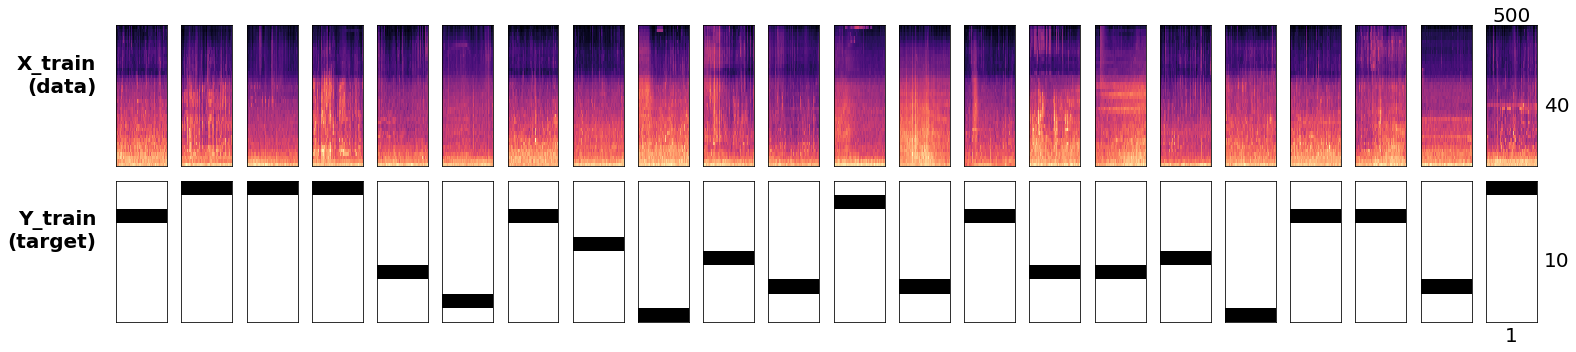

In [27]:
example_ids = numpy.random.choice(range(X_train.shape[0]), 22, replace=False)
fig, axes = plt.subplots(2, len(example_ids), figsize=(22, 5))
fig.subplots_adjust(top=1.0, bottom=0.0, right=1.0, hspace=0.00, wspace=0.00)
for i, id in enumerate(example_ids):
    current_x = X_train[id,:,:]
    current_y = Y_train[id,:]
        
    plt.sca(axes[0, i])
    dcase_util.containers.FeatureContainer(current_x).plot(plot=False)
    
    plt.sca(axes[1, i])
    dcase_util.containers.BinaryMatrix2DContainer(numpy.expand_dims(current_y,-1)).plot(plot=False)
    
axes[0, -1].yaxis.set_label_position("right")
axes[0, -1].xaxis.set_label_position("top")
axes[0, -1].set_ylabel('40', rotation=0, fontsize=20, labelpad=20)
axes[0, -1].set_xlabel('500',fontsize=20)

axes[1, -1].yaxis.set_label_position("right")
axes[1, -1].xaxis.set_label_position("bottom")
axes[1, -1].set_ylabel('10', rotation=0, fontsize=20, labelpad=20)
axes[1, -1].set_xlabel('1',fontsize=20)

axes[0, 0].set_ylabel('X_train\n(data)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')
axes[1, 0].yaxis.set_label_position("left")
axes[1, 0].set_ylabel('Y_train\n(target)', rotation=0, fontsize=20, labelpad=20, fontweight='bold', ha='right')    

plt.tight_layout()

# Neural network structure

Neural network consists of two CNN blocks, the pooling layer, and the output layer. 

Next, we create a neural network structure layer by layer.

In [28]:
feature_vector_length = mel_extractor.n_mels   # Number of mel bands

**Input** layer:

In [29]:
input_layer = Input(
    shape=(feature_vector_length, sequence_length), 
    name='Input'
)

**Reshaping** layer to add channel axis into input data:

In [30]:
x = Reshape(
    target_shape=(feature_vector_length, sequence_length, 1), 
    name='Input_Reshape'
)(input_layer)

In [31]:
print('Output shape','(sequence, frequency, time, channel):\n', x.shape)

Output shape (sequence, frequency, time, channel):
 (None, 40, 500, 1)


Two convolutional **layer groups** consisting of:

1) **Convolution** to capture context and extract high-level features: <br>*kernel 5x5 and filters 64*

In [32]:
x = Conv2D(
    filters=64, 
    kernel_size=(5, 5), 
    activation='linear', 
    padding='same', 
    data_format='channels_last',
    name='Conv1'
)(x)

2) **Batch normalization** to enable higher learning rates

In [33]:
x = BatchNormalization(
    axis=-1, 
    name='Conv1_BatchNorm'
)(x)

3) **Activation** (ReLu) to introduce non-linearity

In [34]:
x = Activation(
    activation='relu', name='Conv1_Activation'
)(x)

4) **Pooling** (2D) to extract dominant features

In [35]:
x = MaxPooling2D(
    pool_size=(2, 4), name='Conv1_Pooling'
)(x)

5) **Dropout** to avoid overfitting

In [36]:
x = Dropout(
    rate=0.2, name='Conv1_DropOut'
)(x)

In [37]:
print('Output shape of CNN layer group 1','(sequence, frequency, time, feature):\n', x.shape)

Output shape of CNN layer group 1 (sequence, frequency, time, feature):
 (None, 20, 125, 64)


Second convolutional layer group:

In [38]:
x = Conv2D(filters=64, kernel_size=(5, 5), activation='linear', padding='same', data_format='channels_last', name='Conv2')(x)
x = BatchNormalization(axis=-1, name='Conv2_BatchNorm')(x)
x = Activation(activation='relu', name='Conv2_Activation')(x)
x = MaxPooling2D(pool_size=(2, 2), name='Conv2_Pooling')(x)
x = Dropout(rate=0.2, name='Conv2_DropOut')(x)

In [39]:
print('Output shape of CNN layer group 2','(sequence, frequency, time, feature):\n', x.shape)

Output shape of CNN layer group 2 (sequence, frequency, time, feature):
 (None, 10, 62, 64)


**Global max pooling** is applied to the output of the last convolutional layer group to summarize output into a **single vector**:

In [40]:
x = GlobalMaxPooling2D(
    data_format='channels_last', 
    name='GlobalPooling'
)(x)

In [41]:
print('Output shape','(sequence, feature):\n', x.shape)

Output shape (sequence, feature):
 (None, 64)


**Output layer** as fully-connected layer with a softmax activation:

In [42]:
output_layer = Dense(
    units=len(db.scene_labels()), 
    activation='softmax', 
    name='Output'
)(x)

In [43]:
print('Output shape','(sequence, class):\n', output_layer.shape)

Output shape (sequence, class):
 (None, 10)


Create a model network:

In [44]:
model = Model(inputs=input_layer, outputs=output_layer)

In [45]:
dcase_util.tfkeras.model_summary_string(
    keras_model=model,
    mode='extended', 
    show_parameters=False, 
    display=True
) # alternative for print(model.summary()) to get html table

Layer name,Layer type,Output shape,Parameters
Input,InputLayer,"[(None, 40, 500)]",0
Input_Reshape,Reshape,"(None, 40, 500, 1)",0
Conv1,Conv2D,"(None, 40, 500, 64)",1664
Conv1_BatchNorm,BatchNorm,"(None, 40, 500, 64)",256
Conv1_Activation,Activation,"(None, 40, 500, 64)",0
Conv1_Pooling,MaxPooling2D,"(None, 20, 125, 64)",0
Conv1_DropOut,Dropout,"(None, 20, 125, 64)",0
Conv2,Conv2D,"(None, 20, 125, 64)",102464
Conv2_BatchNorm,BatchNorm,"(None, 20, 125, 64)",256
Conv2_Activation,Activation,"(None, 20, 125, 64)",0


# Training

Key parameters:

- **Loss** &ndash; function used to measure the difference between target and prediction <br> `categorical_crossentropy`
- **Metric** &ndash; evaluated for training and validation data during the learning process<br> `categorical_accuracy`
- **Optimizer** &ndash; function used to update the model to minimize the loss
- **Learning rate** &ndash; how much model parameters are updated at each step
- **Batch size** &ndash; how many learning examples are processed before updating model parameters
- **Epochs** &ndash; how many times all learning data is gone through during the training procedure

In [46]:
callback_list=[
    dcase_util.tfkeras.ProgressLoggerCallback(
        epochs=100, 
        metric='categorical_accuracy', 
        loss='categorical_crossentropy', 
        output_type='console', 
        show_timing=False,
    ),
    dcase_util.tfkeras.StasherCallback(
        epochs=100, 
        monitor='val_categorical_accuracy'
    )
]

Compile the model:

In [47]:
model.compile(
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.001, decay=0.001)
)

Start learning process:

In [ ]:
# Track power consumption during the training
tracker = EmissionsTracker("Sound Classification Tutorial", output_dir=os.path.join('data', 'training_codecarbon'))
tracker.start()
# Track time
start_time = time.time()
# Start training process
history = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_validation, Y_validation),
    callbacks=callback_list,
    verbose=0,
    epochs=100,
    batch_size=16
)
# Stop tracking
stop_time = time.time()
tracker.stop()

  Training
            Loss                                Metric                             
            categorical_crossentropy            categorical_accuracy               
  Epoch     Train             Val               Train             Val              
  -------   ---------------   ---------------   ---------------   ---------------  
  1         1.5075            1.6670            0.4557            0.3602           
  2         1.3583            1.4756            0.4981            0.4542           
  3         1.2583            1.4834            0.5467            0.4814           
  4         1.1897            1.4104            0.5622            0.4306           
  5         1.1327            1.3432            0.5936            0.4628           
  6         1.0801            1.9897            0.6101            0.3099           
  7         1.0256            1.2844            0.6352            0.5231           
  8         0.9925            1.4193            0.6432           

In [ ]:
print('Time used for training: {time:.4} min'.format(time=(stop_time - start_time)/60))
print('Total energy consumed during training: {value:0.3f} kWh'.format(value=tracker._total_energy.kWh))

## Best performing model

The best performing model was stored during the training process in `StasherCallback`:

In [ ]:
for callback in callback_list:
    if isinstance(callback, dcase_util.tfkeras.StasherCallback):                
        model.set_weights(callback.get_best()['weights'])       # Fetch the best performing model        
        callback.show()                                         # Show information
        break

Save model and training history:

In [ ]:
# Save model
model.save(model_filename)

# Save training history
dcase_util.files.Serializer().save_cpickle(
    filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle'), 
    data=history.history
)

## Training history

In [ ]:
hist = dcase_util.files.Serializer().load_cpickle(
    filename=os.path.join(data_storage_path, 'model_asc_training_history.cpickle')
)

In [ ]:
epochs = range(1, len(hist['loss']) + 1)
fig = plt.figure(figsize=(19,8))
plt.subplot(2,1,1)
plt.plot(epochs, hist['loss'], color='red', linewidth=3, label='Training loss')
#plt.plot(epochs, hist['val_loss'], color='green', linewidth=3, label='Validation loss')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_loss'])), color='#6aa84f', linewidth=3, label='Validation loss')
plt.ylabel('Loss', fontsize=18)
plt.legend(loc='best', fontsize=16)
panel = plt.gca()
panel.get_xaxis().set_visible(False)
panel.set_xlim([1,len(hist['loss']) + 1])

plt.subplot(2,1,2)
plt.plot(epochs, hist['categorical_accuracy'], color='red', linewidth=3, label='Training accuracy')
#plt.plot(epochs, hist['val_categorical_accuracy'], color='green', linewidth=3, label='Validation accuracy')
plt.fill_between(epochs, numpy.squeeze(numpy.array(hist['val_categorical_accuracy'])), color='#6aa84f', linewidth=3, label='Validation accuracy')

acc_min_index = numpy.argmax(hist['val_categorical_accuracy'])
plt.axhline(hist['val_categorical_accuracy'][acc_min_index], color='green', linestyle='-', linewidth=5, alpha=0.5)
plt.annotate('Maximum accuracy for validation set', xy=(len(hist['loss']),hist['val_categorical_accuracy'][acc_min_index]+0.05), fontsize=14, ha='right')
panel = plt.gca()
panel.set_xlim([1,len(hist['loss']) + 1])

plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()

# Testing stage

In [ ]:
model = keras.models.load_model(model_filename) # Load model

**Extract** features for test item:

In [ ]:
# Get test item
item = db.test(fold=1)[0]

# Extract features
features = mel_extractor.extract(
    AudioContainer().load(filename=item.filename, mono=True)
)[:,:sequence_length]

In [ ]:
dcase_util.containers.FeatureContainer(features, time_resolution=0.02).plot(figsize=(18,2))

**Reshape** the matrix to match the model input:

In [ ]:
input_data = numpy.expand_dims(features, 0)

In [ ]:
print('input_data shape', '(sequence, frequency, time):\n', input_data.shape)

Feed input data into the model to get **probabilities for each scene class**:

In [ ]:
probabilities = model.predict(x=input_data)

In [ ]:
probabilities

**Classify** by selecting the class giving **maximum output**:

In [ ]:
frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
    probabilities=probabilities.T,
    binarization_type='frame_max'
).T  

In [ ]:
frame_decisions

Scene label:

In [ ]:
scene_labels[numpy.argmax(frame_decisions)]

## Going through all test material

In [ ]:
res = dcase_util.containers.MetaDataContainer(filename=os.path.join(data_storage_path, 'results_asc.csv'))

for item in db.test(fold=1):
    print('Test', db.absolute_to_relative_path(item.filename))
    # Load features
    features = get_feature_matrix(item.filename)[:,:sequence_length]
    #features = mel_extractor.extract(
    #    dcase_util.containers.AudioContainer().load(filename=item.filename, mono=True)
    #)[:,:sequence_length]
    input_data = numpy.expand_dims(features, 0)

    # Get network output
    probabilities = model.predict(x=input_data)

    # Binarization and getting estimated scene label
    frame_decisions = dcase_util.data.ProbabilityEncoder().binarization(
        probabilities=probabilities.T,
        binarization_type='frame_max'
    )   
    estimated_scene_label = scene_labels[numpy.argmax(frame_decisions)]
    
    # Store result into results container
    res.append(
        {
            'filename': db.absolute_to_relative_path(item.filename),
            'scene_label': estimated_scene_label
        }
    )
    
# Save results container
res.save().show(mode='print')

# Evaluation

## Preparing data for evaluation

In [ ]:
# Load reference and system output
reference_scene_list = db.eval(fold=1)
estimated_scene_list = dcase_util.containers.MetaDataContainer(
    filename=os.path.join(data_storage_path, 'results_asc.csv')
).load()
# Collect test items into lists in same order
y_true = []
y_pred = []
for item_id, item in enumerate(reference_scene_list):
    y_true.append(item.scene_label)
    for item_estimated in estimated_scene_list:
        if os.path.split(item_estimated.filename)[-1] == os.path.split(item.filename)[-1]:
            y_pred.append(item_estimated.scene_label)
            break

## Calculating metric

In [74]:
import sklearn

# Get confusion matrix with counts
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

# Transform matrix into percentages, normalize row-wise
conf = confusion_matrix * 100.0 / confusion_matrix.sum(axis=1)[:, numpy.newaxis]  

# Fetch class-wise accuracies from diagonal
class_wise_accuracies = numpy.diag(conf)                

# Calculate overall accuracy
macro_averaged_accuracy = numpy.mean(class_wise_accuracies)

In [80]:
print('Macro-averaged accuracy: {value:.1f} %'.format(value=macro_averaged_accuracy))

Macro-averaged accuracy: 61.6 %


## Class-wise accuracies

In [77]:
labels = db.scene_labels()
labels.append('Average')
values = class_wise_accuracies
values = numpy.append(values, numpy.mean(class_wise_accuracies))
log.table(
    cell_data=[
        labels,values
    ],
    column_headers=['Scene label', 'Accuracy'],
    column_types=['str30', 'float1'],
    row_separators=[10],
    scaling=120,
)

Scene label,Accuracy
airport,69.1
bus,56.2
metro,62.5
metro_station,35.5
park,85.5
public_square,53.2
shopping_mall,64.5
street_pedestrian,44.5
street_traffic,81.3
tram,64.0


## Confusion matrix

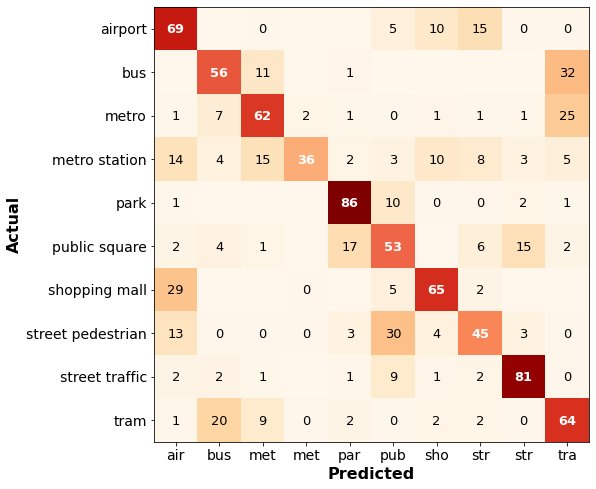

In [78]:
fig = plt.figure(figsize=(8,8))    
plt.imshow(conf, cmap=plt.cm.OrRd)
labels = []
labels_short = []
for label in db.scene_labels():
    labels.append(str(label.replace('_', ' ')))
    labels_short.append(label[0:3])    
plt.yticks(range(len(scene_labels)), labels, fontsize=14)
plt.xticks(range(len(scene_labels)), labels_short, fontsize=14)
plt.ylabel('Actual', fontsize=16, fontweight="bold")
plt.xlabel('Predicted', fontsize=16, fontweight="bold")
for x in range(len(scene_labels)):
    for y in range(len(scene_labels)):
        if conf[y, x] > 0:
            plt.text(x, y + 0.1, "{:.0f}".format(conf[y, x]), 
                     fontsize=13, ha='center', 
                     color= 'white' if (x==y) else 'black', 
                     weight= 'bold' if (x==y) else 'normal')  

## Confidence interval for the accuracy

In [79]:
from statsmodels.stats import proportion
Nref = len(y_true)
Ncorr = numpy.sum(numpy.diag(confusion_matrix))
ci95 = proportion.proportion_confint(
    count=Ncorr,
    nobs=Nref,
    alpha=0.05,
    method='normal'
)
print('95% confidence interval:', '{0:2.2f} - {1:2.2f}'.format(ci95[0]*100, ci95[1]*100))

95% confidence interval: 59.78 - 63.57


# How to improve:

- Collect **more material**
- Use **data augmentation** to generate more variability in learning examples
- Use **transfer learning** techniques to distill knowledge from other tasks
- Use different **network architectures**